In [54]:
import torch

# 判断是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"当前使用的设备是: {device}")

当前使用的设备是: cuda


In [55]:
%matplotlib inline
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

from torch import nn
import numpy as np
import torch
import os
import random
from tqdm import tqdm as tqdm
from IPython import display

from models.vgg import VGG_A
from models.vgg import VGG_BatchNorm # you need to implement this network
from data.loaders import get_cifar_loader

# ## Constants (parameters) initialization
device_id = [0]
num_workers = 0
batch_size = 128

# add our package dir to path 
module_path = os.path.dirname(os.getcwd())
home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

# Make sure you are using the right device.
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
device = torch.device("cuda:0".format(3) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 4060 Laptop GPU


In [56]:
def unnormalize(img, mean, std):
    """Unnormalize a tensor image."""
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

Image batch shape: torch.Size([128, 3, 32, 32])
Label batch shape: torch.Size([128])
First 10 labels: [6, 0, 1, 3, 2, 6, 9, 2, 3, 9]


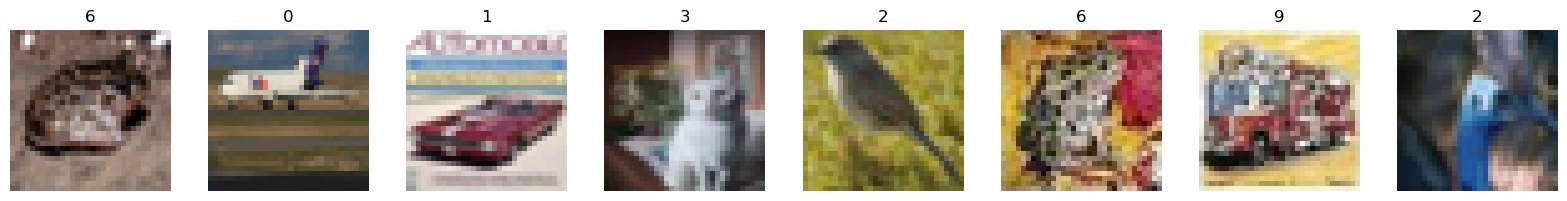

In [57]:
# Initialize your data loader and
# make sure that dataloader works
# as expected by observing one
# sample from it.
train_loader = get_cifar_loader(train=True)
val_loader = get_cifar_loader(train=False)
for X, y in train_loader:
    print(f"Image batch shape: {X.shape}")   # e.g., torch.Size([128, 3, 32, 32])
    print(f"Label batch shape: {y.shape}")   # e.g., torch.Size([128])
    print(f"First 10 labels: {y[:10].tolist()}")

    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i in range(8):
        img = unnormalize(X[i].clone(), mean, std)  # 反标准化，不影响原数据
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{y[i].item()}")
    
    plt.tight_layout()
    plt.show()
    break

In [58]:
print(len(train_loader)*128,len(train_loader))

50048 391


In [59]:
print(len(val_loader)*128)

10112


In [60]:
# This function is used to calculate the accuracy of model classification
def get_accuracy():
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total
    pass

In [61]:
# Set a random seed to ensure reproducible results
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [62]:

# We use this function to complete the entire
# training process. In order to plot the loss landscape,
# you need to record the loss value of each step.
# Of course, as before, you can test your model
# after drawing a training round and save the curve
# to observe the training
def train(model, optimizer, criterion, train_loader, val_loader, scheduler=None, epochs_n=100, best_model_path=None):
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
   

    batches_n = len(train_loader)
    losses_list = []
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()

        loss_list = []  # use this to record the loss value of each step
        grad = []  # use this to record the loss gradient of each step
        learning_curve[epoch] = 0  # maintain this to plot the training curve

        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            # You may need to record some variable values here
            # if you want to get loss gradient, use
            # grad = model.classifier[4].weight.grad.clone()
            ## --------------------
            # Add your code
            loss_value = loss.item()
            loss_list.append(loss_value)
            learning_curve[epoch] += loss_value
            
            loss.backward()
            
            grad_current = model.classifier[4].weight.grad.clone().cpu().numpy()
            grad.append(grad_current)
            ## -------------------
            
            optimizer.step()

        losses_list.append(loss_list)
        grads.append(grad)
        

        learning_curve[epoch] /= batches_n
        
       
        model.eval()
        
        # 训练集准确率
        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for data in train_loader:
                x, y = data[0].to(device), data[1].to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                train_total += y.size(0)
                train_correct += (predicted == y).sum().item()
        train_accuracy = train_correct / train_total
        train_accuracy_curve[epoch] = train_accuracy
        
        # 验证集准确率
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in val_loader:
                x, y = data[0].to(device), data[1].to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()
        val_accuracy = val_correct / val_total
        val_accuracy_curve[epoch] = val_accuracy
        
        
        # 更新最佳模型
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            if best_model_path is not None:
                torch.save(model.state_dict(), best_model_path)
        
        
        print(f'Epoch {epoch+1}/{epochs_n} - '
              f'Train Loss: {learning_curve[epoch]:.4f} | '
              f'Train Acc: {train_accuracy:.4f} | '
              f'Val Acc: {val_accuracy:.4f} | '
              f'Best Val Acc: {max_val_accuracy:.4f} ')
        
        # display.clear_output(wait=True)
        # f, axes = plt.subplots(1, 2, figsize=(15, 3))
        # axes[0].plot(learning_curve)
        # 
        # # Test your model and save figure here (not required)
        # # remember to use model.eval()
        # ## --------------------
        # # Add code as needed
        # axes[0].plot(learning_curve)
        # axes[0].set_title('Training Loss')
        # axes[0].set_xlabel('Epoch')
        # axes[0].set_ylabel('Loss')
        # 
        # # 绘制准确率曲线
        # axes[1].plot(train_accuracy_curve, label='Train')
        # axes[1].plot(val_accuracy_curve, label='Validation')
        # axes[1].set_title('Accuracy')
        # axes[1].set_xlabel('Epoch')
        # axes[1].set_ylabel('Accuracy')
        # axes[1].legend()
        # 
        # plt.show()
        ## --------------------

    return learning_curve, train_accuracy_curve, val_accuracy_curve, losses_list, grads


In [63]:
epo = 20


set_random_seeds(seed_value=2020, device=device)
model = VGG_A()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
learning_curve, train_accuracy_curve, val_accuracy_curve, loss, grads = train(model, optimizer, criterion, train_loader, val_loader, epochs_n=epo,best_model_path='best_model.pth')


  5%|▌         | 1/20 [01:15<23:52, 75.40s/epoch]

Epoch 1/20 - Train Loss: 1.8409 | Train Acc: 0.3701 | Val Acc: 0.3700 | Best Val Acc: 0.3700 


 10%|█         | 2/20 [02:30<22:32, 75.13s/epoch]

Epoch 2/20 - Train Loss: 1.3961 | Train Acc: 0.5837 | Val Acc: 0.5654 | Best Val Acc: 0.5654 


 15%|█▌        | 3/20 [03:43<21:00, 74.17s/epoch]

Epoch 3/20 - Train Loss: 1.0450 | Train Acc: 0.6956 | Val Acc: 0.6732 | Best Val Acc: 0.6732 


 20%|██        | 4/20 [04:56<19:41, 73.85s/epoch]

Epoch 4/20 - Train Loss: 0.8556 | Train Acc: 0.7468 | Val Acc: 0.7040 | Best Val Acc: 0.7040 


 25%|██▌       | 5/20 [06:09<18:24, 73.60s/epoch]

Epoch 5/20 - Train Loss: 0.7228 | Train Acc: 0.7858 | Val Acc: 0.7278 | Best Val Acc: 0.7278 


 30%|███       | 6/20 [07:23<17:10, 73.59s/epoch]

Epoch 6/20 - Train Loss: 0.6255 | Train Acc: 0.8254 | Val Acc: 0.7475 | Best Val Acc: 0.7475 


 35%|███▌      | 7/20 [08:36<15:55, 73.52s/epoch]

Epoch 7/20 - Train Loss: 0.5406 | Train Acc: 0.8412 | Val Acc: 0.7433 | Best Val Acc: 0.7475 


 40%|████      | 8/20 [09:50<14:40, 73.41s/epoch]

Epoch 8/20 - Train Loss: 0.4665 | Train Acc: 0.8639 | Val Acc: 0.7498 | Best Val Acc: 0.7498 


 45%|████▌     | 9/20 [11:03<13:28, 73.46s/epoch]

Epoch 9/20 - Train Loss: 0.4073 | Train Acc: 0.8867 | Val Acc: 0.7546 | Best Val Acc: 0.7546 


 50%|█████     | 10/20 [12:17<12:16, 73.64s/epoch]

Epoch 10/20 - Train Loss: 0.3486 | Train Acc: 0.8987 | Val Acc: 0.7508 | Best Val Acc: 0.7546 


 55%|█████▌    | 11/20 [13:31<11:04, 73.81s/epoch]

Epoch 11/20 - Train Loss: 0.3019 | Train Acc: 0.9322 | Val Acc: 0.7667 | Best Val Acc: 0.7667 


 60%|██████    | 12/20 [14:45<09:50, 73.83s/epoch]

Epoch 12/20 - Train Loss: 0.2551 | Train Acc: 0.9336 | Val Acc: 0.7575 | Best Val Acc: 0.7667 


 65%|██████▌   | 13/20 [15:58<08:35, 73.64s/epoch]

Epoch 13/20 - Train Loss: 0.2318 | Train Acc: 0.9319 | Val Acc: 0.7492 | Best Val Acc: 0.7667 


 70%|███████   | 14/20 [17:12<07:21, 73.55s/epoch]

Epoch 14/20 - Train Loss: 0.1964 | Train Acc: 0.9518 | Val Acc: 0.7589 | Best Val Acc: 0.7667 


 75%|███████▌  | 15/20 [18:25<06:07, 73.58s/epoch]

Epoch 15/20 - Train Loss: 0.1697 | Train Acc: 0.9637 | Val Acc: 0.7668 | Best Val Acc: 0.7668 


 80%|████████  | 16/20 [19:39<04:54, 73.64s/epoch]

Epoch 16/20 - Train Loss: 0.1569 | Train Acc: 0.9673 | Val Acc: 0.7587 | Best Val Acc: 0.7668 


 85%|████████▌ | 17/20 [20:53<03:41, 73.74s/epoch]

Epoch 17/20 - Train Loss: 0.1424 | Train Acc: 0.9656 | Val Acc: 0.7562 | Best Val Acc: 0.7668 


 90%|█████████ | 18/20 [22:08<02:27, 73.95s/epoch]

Epoch 18/20 - Train Loss: 0.1224 | Train Acc: 0.9702 | Val Acc: 0.7613 | Best Val Acc: 0.7668 


 95%|█████████▌| 19/20 [23:22<01:14, 74.11s/epoch]

Epoch 19/20 - Train Loss: 0.1097 | Train Acc: 0.9733 | Val Acc: 0.7602 | Best Val Acc: 0.7668 


100%|██████████| 20/20 [24:36<00:00, 73.83s/epoch]

Epoch 20/20 - Train Loss: 0.0999 | Train Acc: 0.9754 | Val Acc: 0.7639 | Best Val Acc: 0.7668 


In [64]:
print(train_accuracy_curve)

[0.3701, 0.58374, 0.69556, 0.74678, 0.78578, 0.82538, 0.84124, 0.8639, 0.88674, 0.89872, 0.93224, 0.93362, 0.93188, 0.9518, 0.96366, 0.96734, 0.9656, 0.97016, 0.97334, 0.9754]


In [65]:
print(val_accuracy_curve)

[0.37, 0.5654, 0.6732, 0.704, 0.7278, 0.7475, 0.7433, 0.7498, 0.7546, 0.7508, 0.7667, 0.7575, 0.7492, 0.7589, 0.7668, 0.7587, 0.7562, 0.7613, 0.7602, 0.7639]


In [66]:
print(learning_curve)

[1.840858788136631, 1.3960515007643444, 1.0449933213041263, 0.8555687961675932, 0.72280477982043, 0.6254721052201507, 0.5406214023185203, 0.46647628341489433, 0.4072621018456681, 0.348610069364538, 0.3019390253307265, 0.2551024032142156, 0.2317807909358493, 0.19644756988643686, 0.16970158280695186, 0.1569177199278951, 0.14239827422496606, 0.12243412958119837, 0.1097296046478974, 0.0998943738324944]


In [67]:
print(len(loss),len(loss[0]))

20 391


In [68]:
print(len(grads),len(grads[0]))

20 391


In [69]:
print(len(grads[0][0][0]))

512


验证保存模型：

In [76]:
model2 = VGG_A().to(device)
model2.load_state_dict(torch.load('best_model_vggA.pth'))
model2.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for data in val_loader:
        x, y = data[0].to(device), data[1].to(device)
        outputs = model2(x)
        _, predicted = torch.max(outputs.data, 1)
        val_total += y.size(0)
        val_correct += (predicted == y).sum().item()
val_accuracy = val_correct / val_total
print(val_accuracy)


0.7668


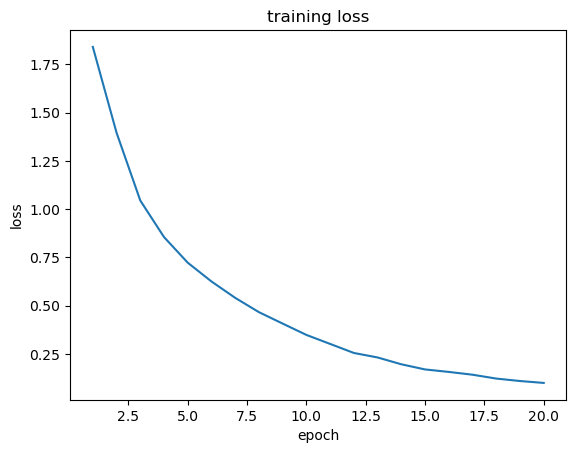

In [70]:
import matplotlib.pyplot as plt

x_index=range(1,21)

plt.plot(x_index, learning_curve, label='Train loss')
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

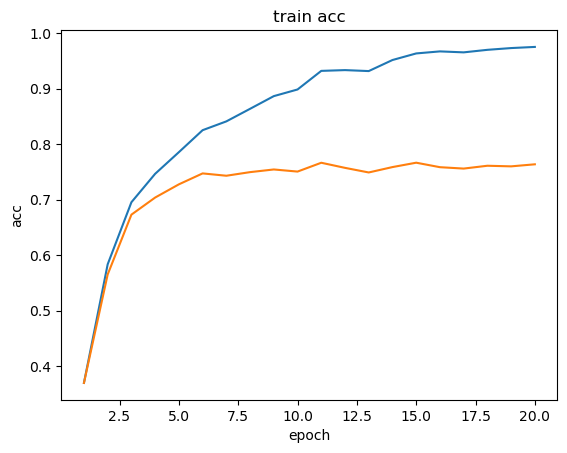

In [71]:
plt.plot(x_index, train_accuracy_curve, label='train acc')
plt.plot(x_index, val_accuracy_curve, label='val acc')
plt.title('train acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

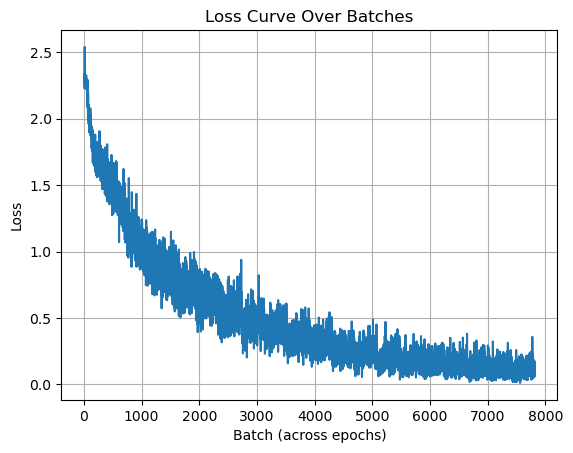

In [72]:
flattened_loss = [l for epoch in loss for l in epoch]

plt.plot(flattened_loss)
plt.title("Loss Curve Over Batches")
plt.xlabel("Batch (across epochs)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [51]:
loss_save_path = './loss_path'
grad_save_path = './grad_path'
train_loss_save_path = './train_loss_path'
train_acc_save_path = './train_acc_path'
val_acc_save_path = './val_acc_path'

os.makedirs(loss_save_path, exist_ok=True)
os.makedirs(grad_save_path, exist_ok=True)
os.makedirs(train_loss_save_path, exist_ok=True)
os.makedirs(train_acc_save_path, exist_ok=True)
os.makedirs(val_acc_save_path, exist_ok=True)

np.savetxt(os.path.join(loss_save_path, 'loss_vggA.txt'), loss, fmt='%s', delimiter=' ')
# np.savetxt(os.path.join(grad_save_path, 'grads_vggA.txt'), grads, fmt='%s', delimiter=' ')
np.save(os.path.join(grad_save_path, "grads_vggA.npy"), grads)
np.savetxt(os.path.join(train_loss_save_path, 'train_loss_vggA.txt'), learning_curve, delimiter=' ')
np.savetxt(os.path.join(train_acc_save_path, 'train_acc_vggA.txt'), train_accuracy_curve, delimiter=' ')
np.savetxt(os.path.join(val_acc_save_path, 'val_acc_vggA.txt'), val_accuracy_curve, delimiter=' ')

